In [5]:
#import necessary modules

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

In [6]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

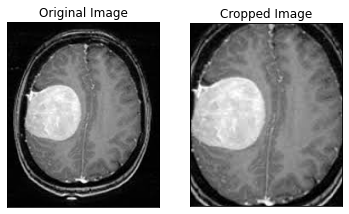

In [7]:
ex_img = cv2.imread('yes/Y1.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

In [8]:
#Load up the data
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '\\' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y


In [9]:
augmented_path = 'augmented data/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2065
X shape is: (2065, 240, 240, 3)
y shape is: (2065, 1)


In [10]:
#plot sample images

def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

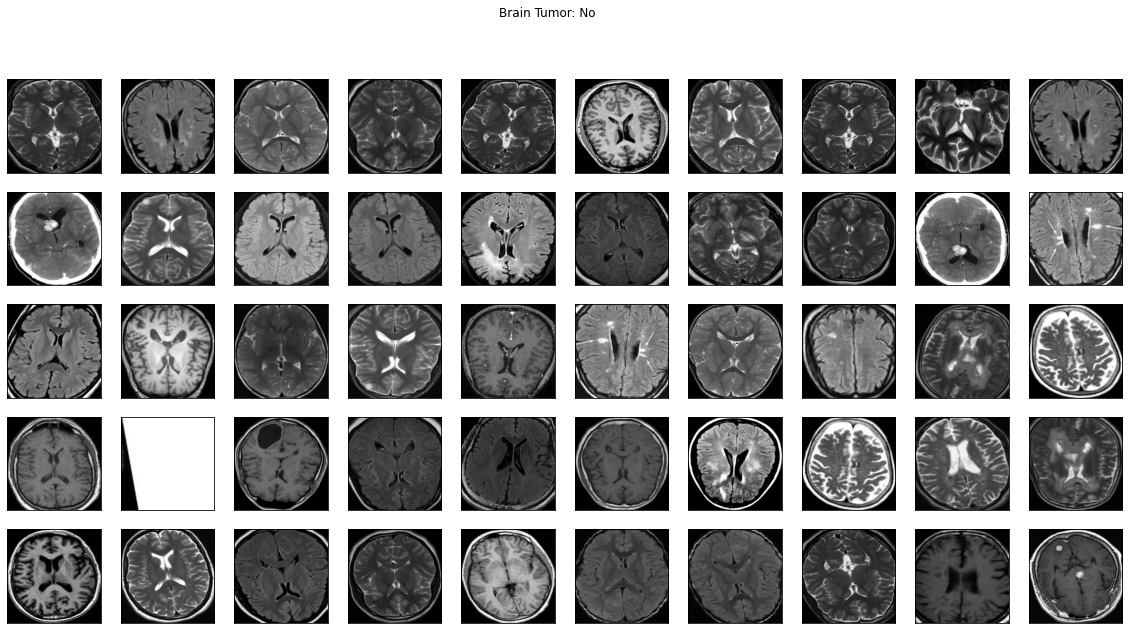

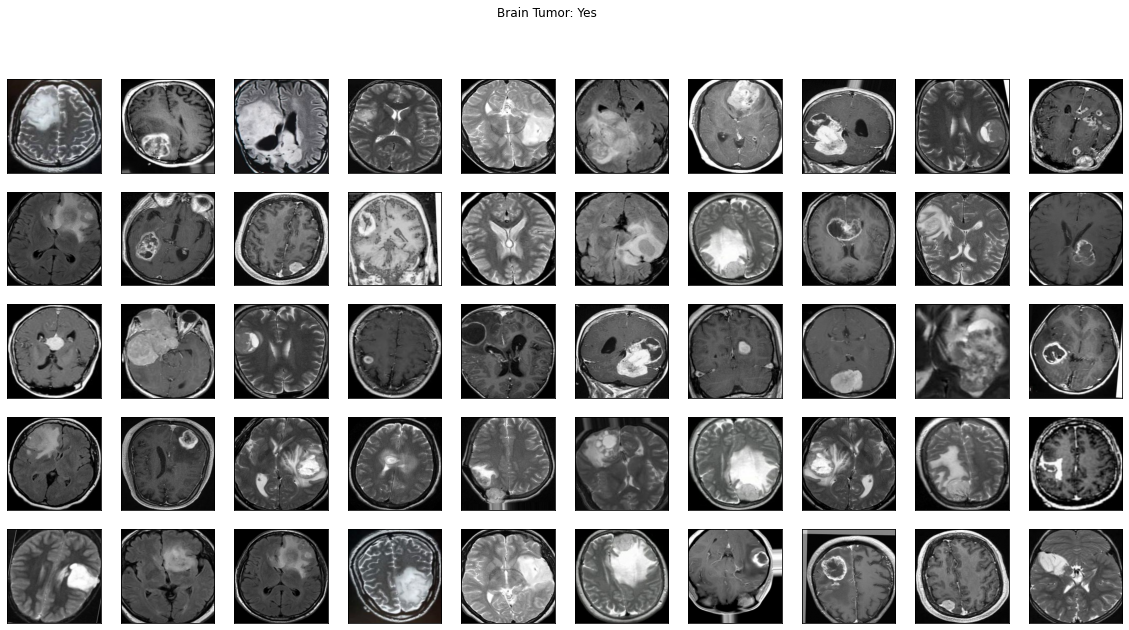

In [11]:
plot_sample_images(X, y)

In [12]:
#split the data
def split_data(X, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [13]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [14]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1445
number of development examples = 310
number of test examples = 310
X_train shape: (1445, 240, 240, 3)
Y_train shape: (1445, 1)
X_val (dev) shape: (310, 240, 240, 3)
Y_val (dev) shape: (310, 1)
X_test shape: (310, 240, 240, 3)
Y_test shape: (310, 1)


In [15]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [16]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

In [17]:
def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

In [18]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [19]:
model = build_model(IMG_SHAPE)

In [20]:
model.summary()


Model: "BrainDetectionModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 244, 244, 3)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 238, 238, 32)      4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 238, 238, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 238, 238, 32)      0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 59, 59, 32)        0         
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 14, 14, 32)

In [25]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [26]:
# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [27]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath="cnn-parameters-improvement-{epoch:02d}-{val_acc:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max'))

In [28]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
46/46 [==============================] - 130s 3s/step - loss: 0.5196 - acc: 0.7571 - val_loss: 0.5682 - val_acc: 0.7742
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.77.model\assets
Epoch 2/10
46/46 [==============================] - 118s 3s/step - loss: 0.3906 - acc: 0.8318 - val_loss: 0.5921 - val_acc: 0.6613
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.66.model\assets
Epoch 3/10
46/46 [==============================] - 108s 2s/step - loss: 0.3946 - acc: 0.8194 - val_loss: 0.6768 - val_acc: 0.5645
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.56.model\assets
Epoch 4/10
46/46 [==============================] - 112s 2s/step - loss: 0.3165 - acc: 0.8706 - val_loss: 0.4804 - val_acc: 0.7387
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.74.model\assets
Epoch 5/10
46/46 [==============================] - 105s 2s/step - loss: 0.2666 - acc: 0.8941 - val_loss: 0.3753 - v

In [29]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
46/46 [==============================] - 112s 2s/step - loss: 0.1889 - acc: 0.9343 - val_loss: 0.2917 - val_acc: 0.8968
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.90.model\assets
Epoch 2/3
46/46 [==============================] - 102s 2s/step - loss: 0.1905 - acc: 0.9287 - val_loss: 0.3140 - val_acc: 0.8968
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.90.model\assets
Epoch 3/3
46/46 [==============================] - 103s 2s/step - loss: 0.1805 - acc: 0.9301 - val_loss: 0.2827 - val_acc: 0.9000
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.90.model\assets
Elapsed time: 0:5:29.4


In [30]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
46/46 [==============================] - 113s 2s/step - loss: 0.1743 - acc: 0.9322 - val_loss: 0.6475 - val_acc: 0.7129
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.71.model\assets
Epoch 2/3
46/46 [==============================] - 106s 2s/step - loss: 0.1319 - acc: 0.9564 - val_loss: 0.4045 - val_acc: 0.8290
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.83.model\assets
Epoch 3/3
46/46 [==============================] - 107s 2s/step - loss: 0.1220 - acc: 0.9599 - val_loss: 0.4008 - val_acc: 0.8355
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.84.model\assets
Elapsed time: 0:5:35.3


In [31]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
46/46 [==============================] - 111s 2s/step - loss: 0.1141 - acc: 0.9668 - val_loss: 0.2720 - val_acc: 0.9194
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.92.model\assets
Epoch 2/3
46/46 [==============================] - 108s 2s/step - loss: 0.1250 - acc: 0.9619 - val_loss: 0.3301 - val_acc: 0.8806
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.88.model\assets
Epoch 3/3
46/46 [==============================] - 108s 2s/step - loss: 0.1104 - acc: 0.9633 - val_loss: 0.3124 - val_acc: 0.8774
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.88.model\assets
Elapsed time: 0:6:26.5


In [32]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/5
46/46 [==============================] - 112s 2s/step - loss: 0.1236 - acc: 0.9522 - val_loss: 0.2786 - val_acc: 0.9097
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.91.model\assets
Epoch 2/5
46/46 [==============================] - 116s 3s/step - loss: 0.1298 - acc: 0.9529 - val_loss: 0.3466 - val_acc: 0.8742
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.87.model\assets
Epoch 3/5
46/46 [==============================] - 110s 2s/step - loss: 0.1121 - acc: 0.9578 - val_loss: 0.2960 - val_acc: 0.8871
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.89.model\assets
Epoch 4/5
46/46 [==============================] - 97s 2s/step - loss: 0.1065 - acc: 0.9599 - val_loss: 0.2998 - val_acc: 0.9032
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.90.model\assets
Epoch 5/5
46/46 [==============================] - 107s 2s/step - loss: 0.1098 - acc: 0.9626 - val_loss: 0.4193 - val_acc

In [33]:
history = model.history.history

In [34]:
for key in history.keys():
    print(key)

loss
acc
val_loss
val_acc


In [35]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['acc']
    val_acc = history['val_acc']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

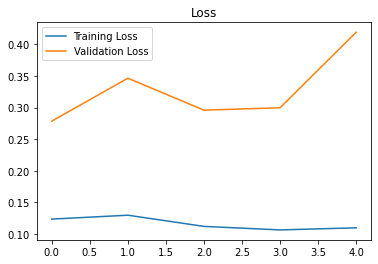

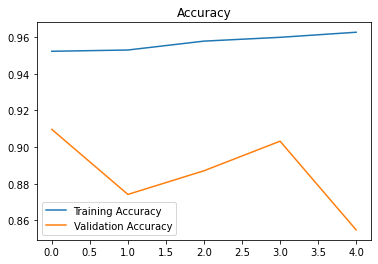

In [36]:
plot_metrics(history)

In [38]:
best_model = load_model(filepath='models/cnn-parameters-improvement-01-0.92.model')

In [39]:
best_model.metrics_names

['loss', 'acc']

In [40]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)

10/10 [==============================] - 6s 535ms/step - loss: 0.2467 - acc: 0.8968


In [41]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.24674376845359802
Test Accuracy = 0.896774172782898


In [42]:
y_test_prob = best_model.predict(X_test)

In [44]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.8980891719745223


In [45]:
y_val_prob = best_model.predict(X_val)

In [46]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.9226006191950464


In [47]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}")

In [48]:
# the whole data
data_percentage(y)

Number of examples: 2065
Percentage of positive examples: 52.54237288135593%, number of pos examples: 1085
Percentage of negative examples: 47.45762711864407%, number of neg examples: 980


In [49]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 1445
Percentage of positive examples: 53.01038062283737%, number of pos examples: 766
Percentage of negative examples: 46.98961937716263%, number of neg examples: 679
Validation Data:
Number of examples: 310
Percentage of positive examples: 51.29032258064516%, number of pos examples: 159
Percentage of negative examples: 48.70967741935484%, number of neg examples: 151
Testing Data:
Number of examples: 310
Percentage of positive examples: 51.61290322580645%, number of pos examples: 160
Percentage of negative examples: 48.38709677419355%, number of neg examples: 150
